# Analytic Green's function in an equilateral triangle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Dataset generation

# 1. 2D grid

In [24]:
grid_size = 50  # 그리드의 크기

Nx = grid_size                                                   # Number of samples
Ny = grid_size                                                   # Number of samples
x = torch.linspace(0, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(0, 1, Ny)                             # Input data for y (N x 1)
xy = torch.meshgrid(x,y)
xy_cartesian = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)
sqrt3 = torch.sqrt(torch.tensor(3.0))
xy_polar = xy_cartesian[torch.logical_and(torch.logical_and(xy_cartesian[:,0] >= 0, xy_cartesian[:,1] <= xy_cartesian[:,0]*sqrt3), xy_cartesian[:,1] <= (1 - xy_cartesian[:,0])*sqrt3)]
xy_grid = xy_polar
eps = 1./grid_size #loss function에서 soft하게 컨디션 적용?
logic = torch.logical_or(xy_cartesian[:,1] == 0, torch.abs(xy_cartesian[:,1] - xy_cartesian[:,0]*sqrt3) < eps)
logic = torch.logical_or(logic, torch.abs(xy_cartesian[:,1] - (1 - xy_cartesian[:,0])*sqrt3) < eps)
logic = torch.logical_and(logic, xy_cartesian[:,1] <= 0.5*sqrt3)
xy_bdry = xy_cartesian[logic]
#xy_bdry = xy_cartesian[torch.abs(torch.sqrt(xy_cartesian[:,0]**2 + xy_cartesian[:,1]**2) - 1.0) < eps]

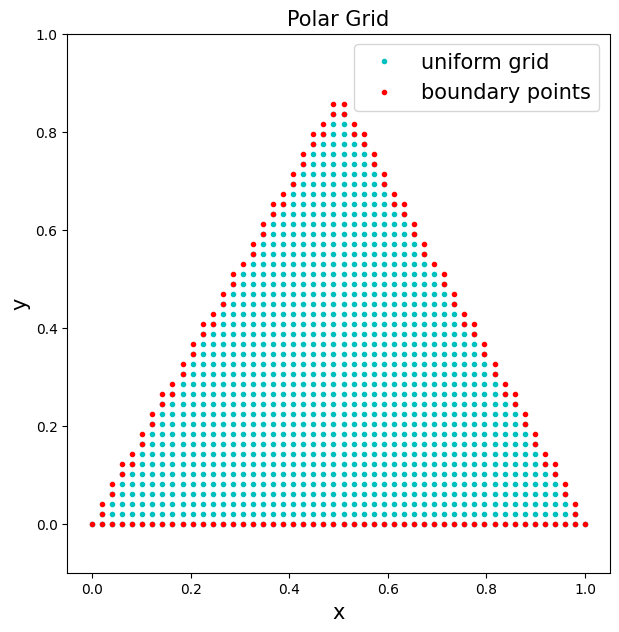

In [29]:
plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Polar Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.ylim([-0.1,1.0])
plt.savefig('drm_data')

# True Green's function

In [204]:
import matplotlib.pyplot as plt
import torch
import time

x_2 = torch.tensor(0.5)
y_2 = 0.5/sqrt3
x_2, y_2 = 0.3, 0.2
k = 10.0

def true_green_triangle(x, y, x_2, y_2):
    N_cutoff = 50
    M_cutoff = 50

    def eigenfunction_triangle(x, y, m, n):
        def exp_mn(x, y, mmm, nnn):
            return torch.exp(2*torch.pi*1j/3*(mmm*x + (2*nnn-mmm)*y/sqrt3))

        mn_list = [(-n, m - n)]
        mn_list.append((-n, -m))
        mn_list.append((n-m, -m))
        mn_list.append((n-m, n))
        mn_list.append((m, n))
        mn_list.append((m, m-n))

        valuee = 0
        valuee = valuee + exp_mn(x, y, -n, m-n)
        valuee = valuee - exp_mn(x, y, -n, -m)
        valuee = valuee + exp_mn(x, y, n-m, -m)
        valuee = valuee - exp_mn(x, y, n-m, n)
        valuee = valuee + exp_mn(x, y, m, n)
        valuee = valuee - exp_mn(x, y, m, m-n)
        return valuee

    def eigenvalue_triangle(m, n):
        return 16/27*torch.pi*torch.pi*(m*m + n*n - m*n) + k*k
        
    value = 0
    for n in range(-N_cutoff, N_cutoff + 1):
        for m in range(-M_cutoff, M_cutoff + 1):
            if (m+n) % 3 == 0 and m != 2*n and n != 2*m:
                value = value + torch.conj(eigenfunction_triangle(x, y, m, n))*eigenfunction_triangle(x_2, y_2, m, n)/eigenvalue_triangle(m, n)

    return value.clone().detach()

In [205]:
xy_detach = xy_grid.cpu().detach()
xx = xy_detach[:,0]
yy = xy_detach[:,1]
start = time.time()
zz_true = true_green_triangle(xx, yy, x_2, y_2)
print(f"{time.time()-start:.4f} sec")

1.8221 sec


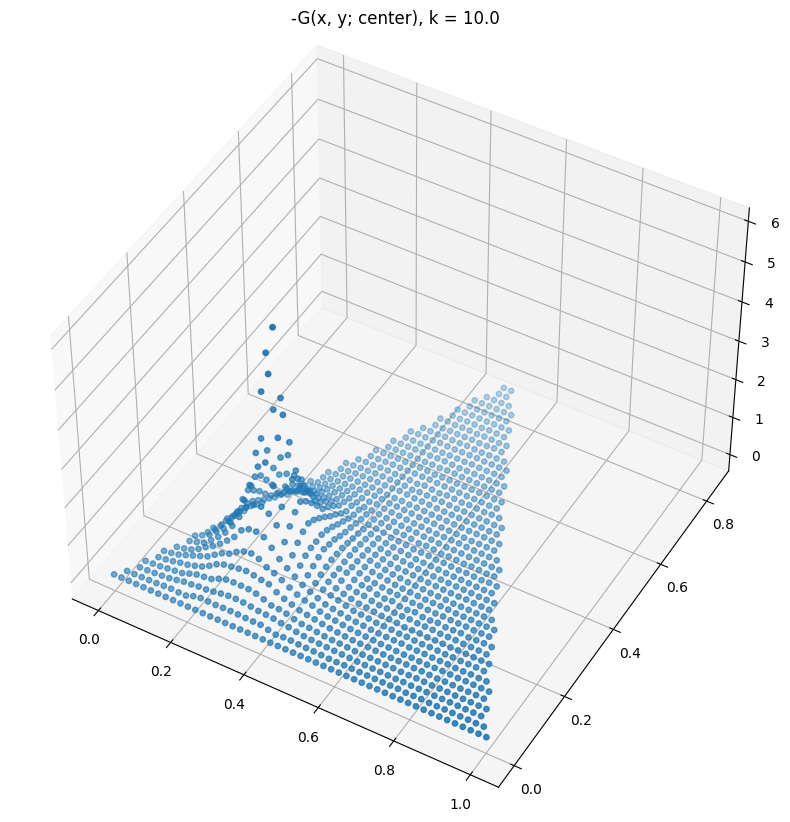

In [206]:
sizeparam = 10
fig = plt.figure(figsize=(sizeparam*3,sizeparam))

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45., azim=-60)
ax.scatter(xx, yy, zz_true, s=15)
plt.title("-G(x, y; center), k = 10.0")
plt.show()

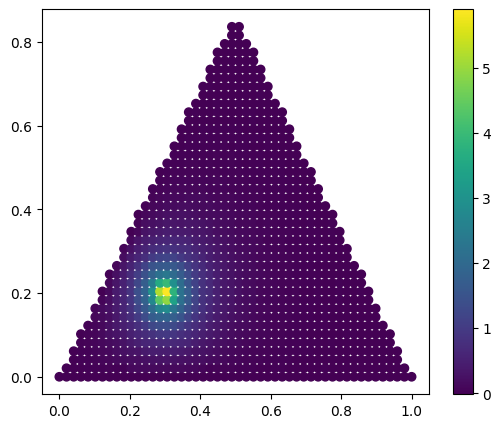

In [207]:
sizeparam = 5
plt.figure(figsize=(1.25*sizeparam,sizeparam))

plt.scatter(xx, yy, c = zz_true)
plt.colorbar()
plt.show()